## Discretisation plus Encoding

What shall we do with the variable after discretisation? should we use the buckets as a numerical variable? or should we use the intervals as categorical variable?

The answer is, you can do either.

If you are building decision tree based algorithms and the output of the discretisation are integers (each integer referring to a bin), then you can use those directly, as decision trees will pick up non-linear relationships between the discretised variable and the target.

If you are building linear models instead, the bins may not necessarily hold a linear relationship with the target. In this case, it may help improve model performance to treat the bins as categories and to one hot encoding, or target guided encodings like mean encoding, weight of evidence, or target guided ordinal encoding.

We can easily do so by combining feature-engine's discretisers and encoders.

## In this demo

We will perform equal frequency discretisation followed by target guided orginal encoding using the titanic dataset

If instead you would like to do weight of evidence or mean target encoding, you need only replace the Feature-engine's encoder.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

In [2]:
# load the the Titanic Dataset

data = pd.read_csv('../titanic.csv',
                   usecols=['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):

    df = data.copy()

    # random sampling
    df[variable + '_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable + '_random'] = random_sample

    return df[variable + '_random']

In [5]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

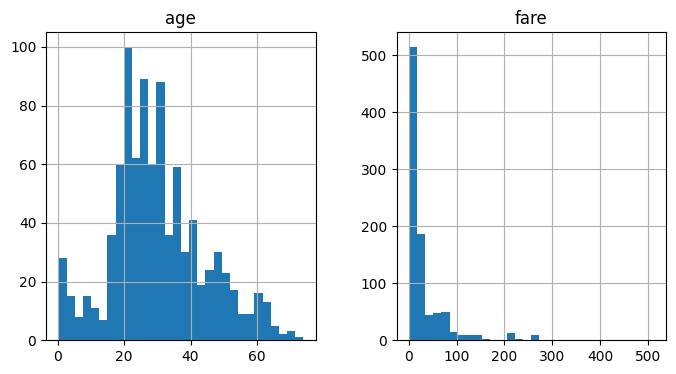

In [6]:
# let's explore the distribution of age

X_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal frequency discretisation with Feature-Engine

In [7]:
# set up the equal frequency discretiser
# to encode variables we need them returned as objects for feature-engine

disc = EqualFrequencyDiscretiser(
    q=10, variables=['age', 'fare'], return_object=True)

# find the intervals
disc.fit(X_train)

# transform train and text
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [8]:
train_t.dtypes

age     object
fare    object
dtype: object

In [9]:
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,7,1
686,2,1


Text(0, 0.5, 'mean of survived')

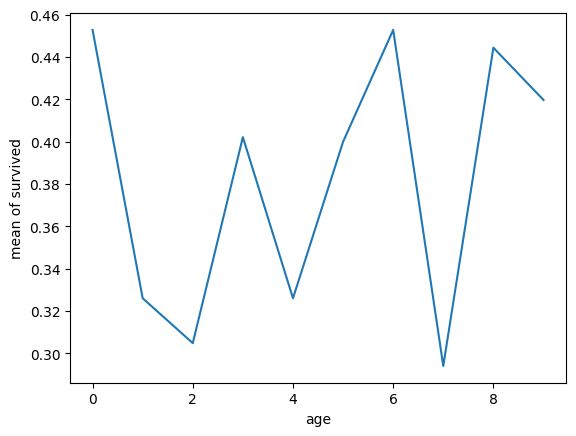

In [10]:
# let's explore if the bins have a linear relationship
# with the target:

pd.concat([train_t, y_train], axis=1).groupby('age')['survived'].mean().plot()
plt.ylabel('mean of survived')

Text(0, 0.5, 'mean of survived')

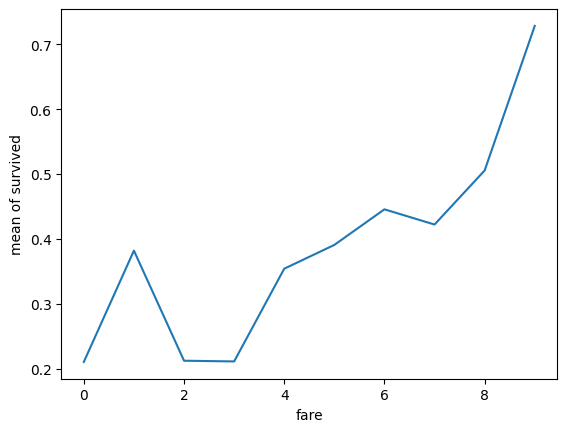

In [11]:
pd.concat([train_t, y_train], axis=1).groupby('fare')['survived'].mean().plot()
plt.ylabel('mean of survived')

None of the variables show a monotonic relationship between the intervals of the discrete variable and the mean of survival. We can encode the intervals to return a monotonic relationship:

# Ordinal encoding with Feature-Engine

In [12]:
enc = OrdinalEncoder(encoding_method = 'ordered')

enc.fit(train_t, y_train)

train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

In [13]:
# in the map, we map bin to position

enc.encoder_dict_

{'age': {7: 0, 2: 1, 1: 2, 4: 3, 5: 4, 3: 5, 9: 6, 8: 7, 0: 8, 6: 9},
 'fare': {0: 0, 3: 1, 2: 2, 4: 3, 1: 4, 5: 5, 7: 6, 6: 7, 8: 8, 9: 9}}

Text(0, 0.5, 'mean of survived')

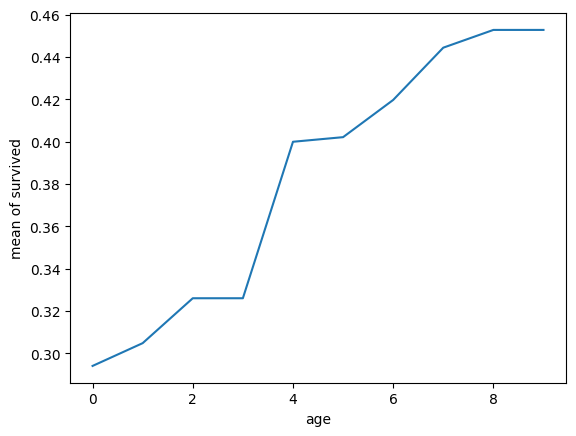

In [14]:
pd.concat([train_t, y_train], axis=1).groupby('age')['survived'].mean().plot()
plt.ylabel('mean of survived')

Text(0, 0.5, 'mean of survived')

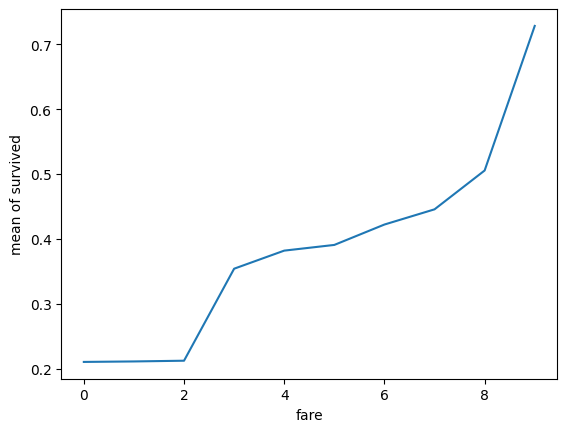

In [15]:
pd.concat([train_t, y_train], axis=1).groupby('fare')['survived'].mean().plot()
plt.ylabel('mean of survived')

Now we obtained a monotonic relationship between variables and target.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**